In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
# import seaborn as sns
import random
import os
import sys
import time
import datetime
from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig,OutputType
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sktime.datasets import load_from_ucr_tsv_to_dataframe
from sktime.datasets import load_from_tsfile
import neptune.new as neptune
import numpy as np 
import time

import matplotlib.pyplot as plt
from collections import OrderedDict

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import RobustScaler

c:\Users\nati\Desktop\Implementations\ImplementationsVenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
X = np.vstack((np.load(r"C:\Users\nati\Desktop\Implementations\FinalProject\sequenced_data_for_VAE_length-160_stride-10_pt1.npy"),
               np.load(r"C:\Users\nati\Desktop\Implementations\FinalProject\sequenced_data_for_VAE_length-160_stride-10_pt2.npy")))
y = np.load(r"C:\Users\nati\Desktop\Implementations\FinalProject\sequenced_data_for_VAE_length-160_stride-10_targets.npy")

In [4]:
X=torch.tensor(X)
# X.view(-1,*(1,160)).size()

In [ ]:
# path = current working directory
path = r'c:\\Users\\nati\\Desktop\\Implementations\\'
subfolders = glob.glob(path + '/FinalProject/Datasets/*/')

datasets = {}
for folder in subfolders:
    datasets[folder.split('\\')[-2]] = {'train': [load_from_tsfile(folder+file) for file in os.listdir(folder) if file.endswith('TRAIN.ts')],
                                        'test': [load_from_tsfile(folder+file) for file in os.listdir(folder) if file.endswith('TEST.ts')]}
    


In [10]:
path

'c:\\Users\\nati\\Desktop\\Implementations\\FinalProject\\FinalProject'

In [25]:
# preprocessing steps:
# 1. reading the data
# 2. expanding dim 
# 3. convert target to numbers
# 4. generate synthetic data. with control of the amount of original data that the generator model uses.
# 5. save the generated data in folder structure 

X,y = load_from_tsfile(r"C:\Users\nati\Desktop\Implementations\FinalProject\Datasets\BasicMotions\BasicMotions_TRAIN.ts")

In [26]:
def preprocess_dgan(df:pd.DataFrame,sequence_length:int):
    df = df.copy(deep=True)
    data = []
    for row in df.iterrows():
        for col in df.columns:
            data.append([row[1][col]])
    data = np.array(data)
    data = data.reshape((df.shape[0], sequence_length, df.shape[1]))
    return data

In [27]:
X = preprocess_dgan(X,100)
# Permute to get the correct shape
# For InceptionTime Permutation is Needed.
X = np.transpose(X, (0, 2, 1))
X.shape

(40, 6, 100)

In [28]:
# Use the inceptionTime model
from InceptionTime import InceptionBlock,Inception,Reshape,Flatten

# Use the inceptionTime model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

# scaler = RobustScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

InceptionTime = nn.Sequential(
                    Reshape((6,100)),
                    InceptionBlock(
                        in_channels=6, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    InceptionBlock(
                        in_channels=32*4, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.AdaptiveAvgPool1d(output_size=1),
                    Flatten(out_features=32*4*1),
                    nn.Linear(in_features=4*32*1, out_features=4)
        )

In [36]:
InceptionTime

Sequential(
  (0): Reshape()
  (1): InceptionBlock(
    (activation): ReLU()
    (inception_1): Inception(
      (bottleneck): Conv1d(6, 32, kernel_size=(1,), stride=(1,), bias=False)
      (conv_from_bottleneck_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (conv_from_bottleneck_2): Conv1d(32, 32, kernel_size=(11,), stride=(1,), padding=(5,), bias=False)
      (conv_from_bottleneck_3): Conv1d(32, 32, kernel_size=(23,), stride=(1,), padding=(11,), bias=False)
      (max_pool): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (conv_from_maxpool): Conv1d(6, 32, kernel_size=(1,), stride=(1,), bias=False)
      (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (inception_2): Inception(
      (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,), bias=False)
      (conv_from_bottleneck_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), pad

In [30]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32, 6, 100), (8, 6, 100), (32,), (8,))

In [ ]:
#Benjamin Updates

In [31]:
def train_dgan(data:np.ndarray,epochs:int, target_name:int, dataset_name:str, original_percentage):
    run = neptune.init_run(
    project="astarteam/FinalProject",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMDI5YzIxMy00NjE1LTQ2MDUtOTk3NS1jNDJhMjIzZDE0NDMifQ==",
    )  # your credentialscredentials

    
    DGAN_param = {'state':'data generation',
                'epochs': epochs,
                'Dataset name': dataset_name, #'Basic Motions'
                'trarget_name':target_name,
                'usage of original data': original_percentage, # percentage of the original data that used to train the data generator model
                'attribute_noise_dim': 10,
                'feature_noise_dim': 10, 
                'attribute_num_layers': 3, 
                'attribute_num_units': 100, 
                'feature_num_layers':  1, 
                'feature_num_units':100, 
                'use_attribute_discriminator': True, 
                'normalization': False, 
                'apply_feature_scaling': True, 
                'apply_example_scaling': True, 
                'binary_encoder_cutoff': 150, 
                'forget_bias': False, 
                'gradient_penalty_coef': 10.0, 
                'attribute_gradient_penalty_coef':10.0, 
                'attribute_loss_coef': 1.0, 
                'generator_learning_rate':  0.001, 
                'generator_beta1':  0.5, 
                'discriminator_learning_rate': 0.001, 
                'discriminator_beta1': 0.5, 
                'attribute_discriminator_learning_rate':  0.001, 
                'attribute_discriminator_beta1': 0.5, 
                'batch_size':  1024, 
                'discriminator_rounds': 1, 
                'generator_rounds': 1, 
                'mixed_precision_training': False }

    run["DGAN_param"] = DGAN_param

    model = DGAN(DGANConfig(
        max_sequence_len=data.shape[1],
        sample_len=4, 
        batch_size=min(1000, data.shape[0]),
        apply_feature_scaling=False,
        apply_example_scaling=False,
        use_attribute_discriminator=False,
        generator_learning_rate=1e-4,
        discriminator_learning_rate=1e-4,
        epochs=epochs,
    ))

    model.train_numpy(
        data,
        feature_types=[OutputType.CONTINUOUS] * data.shape[2],
    )
    time.sleep(2)
    run.stop()
    return model

In [37]:
# Split the data into train and test sets
def split_dataset_by_label(X, y):
    splits = {}
    unique_labels = np.unique(y)
    for label in unique_labels:
        splits[label] = {'X': np.array(X[y == label]), 'y': np.array(y[y == label])}
    return splits

In [38]:
class TimeSeriesDataset(Dataset):    
    def __init__(self, X, y, transform=None, trarget_transform=None):
        self.X = X 
        self.y = y
        self.transform = transform
        self.target_transform = trarget_transform
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self,idx):
        X = self.X[idx]
        y = self.y[idx]
        if self.transform:
            X = self.transform(X)
        if self.target_transform:
            y = self.target_transform(y)
        return torch.tensor(X), torch.tensor(y)

class LSTM_Classifier(nn.Module):
    def __init__(self, input_dim=31, hidden_dim=256, num_layers=1, output_dim=5, dropout=0):
        '''
        input_dim = number of features at each time step 
        hidden_dim = number of features produced by each LSTM cell (in each layer)
        num_layers = number of LSTM layers
        output_dim = number of classes (number of activities)
        '''
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, 
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)
        
        
    def forward(self, X):
        _, (h_n, c_n) = self.lstm(X)  # (h_0, c_0) default to zeros
        out = self.fc(h_n[-1,:,:])
        out = self.softmax(out)
        return out
    

class GRU_Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRU_Classifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device=x.device)
        out, _ = self.gru(x, h0.detach())
        out = self.fc(out[:, -1, :])
        return out
    

In [39]:
def train_generator_per_label(splitted_data, epochs, dataset_name:str, original_percentage:int):
    models = {}
    for label in splitted_data.keys():
        print(f"Training generator for label {label}")
        X = splitted_data[label]['X']
        model = train_dgan(X,epochs,target_name=label, dataset_name=dataset_name, original_percentage=original_percentage)
        models[label] = model
    return models

def generate_data_per_label(models,num_samples):
    generated_data = {}
    for label in models.keys():
        print(f"Generating data for label {label}")
        generated_data[label] = models[label].generate_numpy(num_samples)[1]
    concatenated_data = {'X':np.concatenate([generated_data[label] for label in generated_data.keys()]),
                'y':np.concatenate([np.array([label]*num_samples) for label in generated_data.keys()])}
    return generated_data,concatenated_data

def create_dataloaders_synthetic(X,y,n_splits:int = 1, validation_size:float=0.2):
    ssf = StratifiedShuffleSplit(n_splits=n_splits, test_size=validation_size)
    train_ind, test_ind = next(ssf.split(X,y))
    train_dataloader = DataLoader(TimeSeriesDataset(X[train_ind],y[train_ind]),batch_size=20,shuffle=True)
    validation_dataloader = DataLoader(TimeSeriesDataset(X[test_ind],y[test_ind]),batch_size=20,shuffle=True)
    return train_dataloader, validation_dataloader

def map_label_int(y):    
    label_to_int = {label: i for i, label in enumerate(np.unique(y))}
    int_to_label = {i: label for label, i in label_to_int.items()}
    y_int = np.array([label_to_int[label] for label in y])
    return label_to_int, int_to_label, y_int

def train_loop(data_loader, model,device,loss_fn,optimizer,print_every_n=200):
    model.train()
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    train_loss=0
    tp=0
    for batch,(X,y) in enumerate(data_loader):
        X = X.to(device)
        y = y.type(torch.LongTensor)
        y = y.to(device)
        pred = model(X.float())
        # print(f'Preds : {pred.argmax(1)}')
        # print(f'GT : {y}')
        loss = loss_fn(pred,y)
        train_loss += loss
        tp += (y==pred.argmax(1)).type(torch.float).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss, current = loss.item(), batch*len(X)
        if batch%print_every_n==0:
            print(f'loss={loss:.3f}, {current} / {size}')

    train_loss /= num_batches
    train_acc = tp/size    
    print(f'train accuracy = {train_acc}, val_loss = {train_loss:2f}')
    return train_loss,train_acc

def validation_loop(data_loader,model,device,loss_fn):
    model.eval()
    size=len(data_loader.dataset)
    num_batches = len(data_loader)
    val_loss=0
    tp=0
    with torch.no_grad():
        for X,y in data_loader:
            X = X.to(device)
            y = y.type(torch.LongTensor)
            y = y.to(device)
            pred = model(X.float())
            val_loss += loss_fn(pred,y).item()
            tp += (y==pred.argmax(1)).type(torch.float).sum().item()
        
    val_loss /= num_batches
    val_acc = tp/size
    print(f'validation accuracy = {val_acc}, val_loss = {val_loss:2f}')
    return val_loss,val_acc

def train_and_log(epochs,patience,train_dataloader,validation_dataloader,model,device,criterion,optimizer,save_each_epoch):
    run = neptune.init_run(
    project="astarteam/FinalProject",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMDI5YzIxMy00NjE1LTQ2MDUtOTk3NS1jNDJhMjIzZDE0NDMifQ==",
)  # your credentialscredentials

    params = {"batch_size": 20,
                "learning_rate": lr, 
                "optimizer": "CrossEntropyLoss"}

    run["parameters"] = params
    run['experiment_details'] = {'Dataset name': 'Basic Motions',
                                'Dataset ID': 1,
                                'Pretraining': True,
                                'state':'pretraining'
    }
    best_loss = np.inf
    # define the number of epochs and early stopping patience
    for epoch in range(epochs):
        #Train
        train_loss, train_acc = train_loop(train_dataloader, model, device, criterion, optimizer)
        run["train/accuracy"].log(train_acc)
        run["train/loss"].log(train_loss)
        #Evaluate
        val_loss, val_acc = validation_loop(validation_dataloader, model, device, criterion)
        run["validation/accuracy"].log(val_acc)
        run["validation/loss"].log(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            early_stopping_counter = 0
            if save_each_epoch:
                torch.save(model.state_dict(),f'model_{epoch}.pt')
        # otherwise, increment the early stopping counter
        else:
            early_stopping_counter += 1     
        # if the early stopping counter has reached the patience, stop training
        if early_stopping_counter == patience:
            break
    time.sleep(2)
    print("Finished Training and validation, now uploading to Neptune.")
    run.stop()

In [ ]:
split_data = split_dataset_by_label(X,y)
models = train_generator_per_label(split_data,25,dataset_name='Basic Motions',original_percentage=100)
generated_data,concatenated_data = generate_data_per_label(models,100)
label_to_int, int_to_label, concatenated_data['y'] = map_label_int(concatenated_data['y'])
train_dataloader, validation_dataloader = create_dataloaders_synthetic(concatenated_data['X'],concatenated_data['y'],n_splits=1, validation_size=0.2)

output_dim = len(np.unique(y))
lr = 0.001
best_acc = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_loss = np.inf
model = LSTM_Classifier(num_layers=2,input_dim = 6,hidden_dim=64,output_dim=output_dim,dropout=0.3)
model = model
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
save_each_epoch = True


In [52]:
train_and_log(10,5,train_dataloader,validation_dataloader,model,device,criterion,optimizer,save_each_epoch)

https://app.neptune.ai/astarteam/FinalProject/e/FIN-39
loss=1.386, 0 / 320
train accuracy = 0.225, val_loss = 1.386540
validation accuracy = 0.25, val_loss = 1.386238
loss=1.387, 0 / 320
train accuracy = 0.240625, val_loss = 1.386353
validation accuracy = 0.25, val_loss = 1.386201
loss=1.384, 0 / 320
train accuracy = 0.25, val_loss = 1.386586
validation accuracy = 0.25, val_loss = 1.386176
loss=1.387, 0 / 320
train accuracy = 0.228125, val_loss = 1.386414
validation accuracy = 0.25, val_loss = 1.386148
loss=1.386, 0 / 320
train accuracy = 0.26875, val_loss = 1.386307
validation accuracy = 0.25, val_loss = 1.386110
loss=1.385, 0 / 320
train accuracy = 0.209375, val_loss = 1.386519
validation accuracy = 0.25, val_loss = 1.386059
loss=1.386, 0 / 320
train accuracy = 0.265625, val_loss = 1.386332
validation accuracy = 0.5, val_loss = 1.386002
loss=1.387, 0 / 320
train accuracy = 0.265625, val_loss = 1.386341
validation accuracy = 0.25, val_loss = 1.385949
loss=1.386, 0 / 320
train accuracy

2023-03-25 20:08:43,196 : NeptuneAsyncOpProcessor : ERROR : Error occurred during asynchronous operation processing: Cannot upload file /Users/adirserruya/Documents/GitHub/FinalProject/models/model_9.pt: Path not found or is a not a file.


Finished Training and validation, now uploading to Neptune.
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/astarteam/FinalProject/e/FIN-39/metadata


In [41]:
# InceptionTime 
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(InceptionTime.parameters(), lr=lr)
save_each_epoch = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
InceptionTime.to(device)
label_to_int, int_to_label, y_train = map_label_int(y_train)
og_train_dataloader, og_validation_dataloader = create_dataloaders_synthetic(X_train,y_train,n_splits=1, validation_size=0.4)
train_and_log(10,5,og_train_dataloader,og_validation_dataloader,InceptionTime,device,criterion,optimizer,save_each_epoch)

https://app.neptune.ai/astarteam/FinalProject/e/FIN-104
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
loss=1.607, 0 / 19
train accuracy = 0.42105263157894735, val_loss = 1.606927
validation accuracy = 0.23076923076923078, val_loss = 1.423270
loss=0.955, 0 / 19
train accuracy = 0.5789473684210527, val_loss = 0.954582
validation accuracy = 0.38461538461538464, val_loss = 1.321844
loss=0.618, 0 / 19
train accuracy = 0.8947368421052632, val_loss = 0.618141
validation accuracy = 0.3076923076923077, val_loss = 1.243681
loss=0.434, 0 / 19
train accuracy = 0.9473684210526315, val_loss = 0.433887
validation accuracy = 0.3076923076923077, val_loss = 1.170988
loss=0.312, 0 / 19
train accuracy = 1.0, val_loss = 0.312384
validation accuracy = 0.46153846153846156, val_loss = 1.098770
loss=0.229, 0 / 19
train accuracy = 1.0, val_loss = 0.2285

In [57]:
# LSTM Classifier
output_dim = len(np.unique(y))
lr = 0.001
best_acc = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_loss = np.inf
model = LSTM_Classifier(num_layers=2,input_dim = 6,hidden_dim=64,output_dim=output_dim,dropout=0.3)
model = model
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
save_each_epoch = True


In [58]:
label_to_int, int_to_label, y = map_label_int(y)
og_train_dataloader, og_validation_dataloader = create_dataloaders_synthetic(X,y,n_splits=1, validation_size=0.4)
train_and_log(10,5,og_train_dataloader,og_validation_dataloader,model,device,criterion,optimizer,save_each_epoch)

https://app.neptune.ai/astarteam/FinalProject/e/FIN-42
loss=1.387, 0 / 24
train accuracy = 0.25, val_loss = 1.383063
validation accuracy = 0.25, val_loss = 1.384575
loss=1.385, 0 / 24
train accuracy = 0.25, val_loss = 1.378919
validation accuracy = 0.25, val_loss = 1.383085
loss=1.382, 0 / 24
train accuracy = 0.2916666666666667, val_loss = 1.378849
validation accuracy = 0.25, val_loss = 1.381270
loss=1.380, 0 / 24
train accuracy = 0.3333333333333333, val_loss = 1.375078
validation accuracy = 0.25, val_loss = 1.378898
loss=1.379, 0 / 24
train accuracy = 0.3333333333333333, val_loss = 1.367898
validation accuracy = 0.25, val_loss = 1.375791
loss=1.368, 0 / 24
train accuracy = 0.3333333333333333, val_loss = 1.377235
validation accuracy = 0.25, val_loss = 1.371812
loss=1.364, 0 / 24
train accuracy = 0.25, val_loss = 1.377358
validation accuracy = 0.25, val_loss = 1.366895
loss=1.361, 0 / 24
train accuracy = 0.3333333333333333, val_loss = 1.358438
validation accuracy = 0.25, val_loss = 1.36

2023-03-25 20:22:48,196 : NeptuneAsyncOpProcessor : ERROR : Error occurred during asynchronous operation processing: Cannot upload file /Users/adirserruya/Documents/GitHub/FinalProject/models/model_9.pt: Path not found or is a not a file.


All 57 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/astarteam/FinalProject/e/FIN-42/metadata


In [53]:
# Fine Tune
X.shape

(40, 100, 6)

In [73]:
sequence_length = 100
dataset_paths = glob.glob('dataset\*.ts')

for path in dataset_paths:
    # read data
    X,y = load_from_tsfile(path)
    # expand dim
    data = preprocess_dgan(X,sequence_length)
    # Map the labels to integers
    label_to_int, int_to_label, y_int = map_label_int(y)
    # train data generator and create synthetic data
    data_generator(X, y, train_size)
    # create synthetic dataset
    train_dataloader, validation_dataloader = create_dataset(X,y,n_splits, validation_size)
    # train the model over syn
    
    create_dataset(X,y,n_splits, validation_size)

    


['dataset\\BasicMotions_TEST.ts', 'dataset\\BasicMotions_TRAIN.ts']

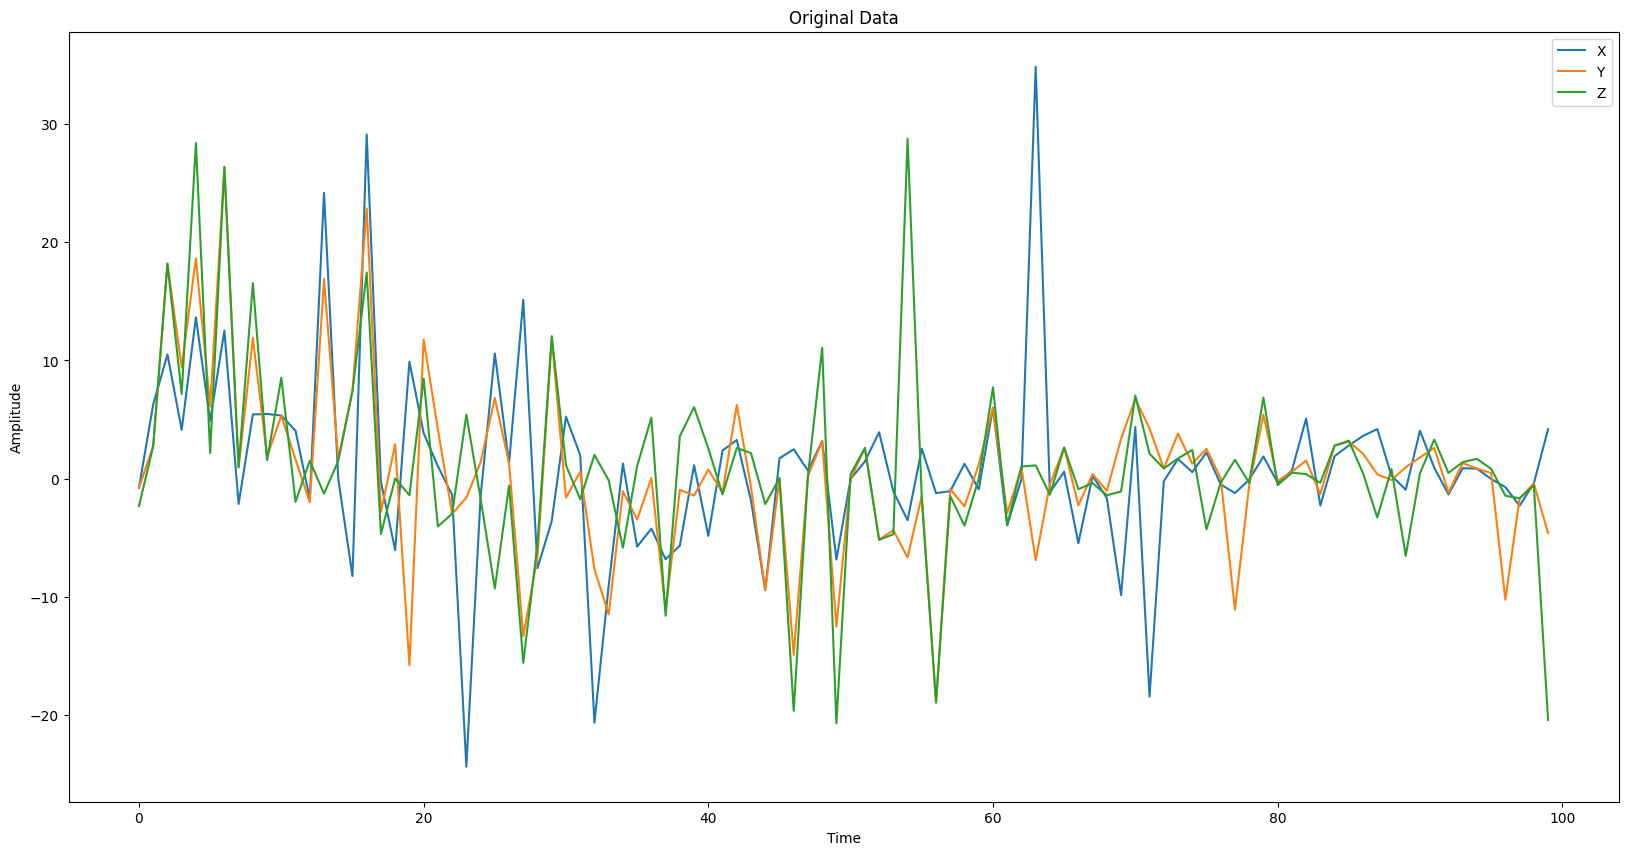

In [65]:
plt.figure(figsize=(20,10))
plt.title('Original Data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(X[y == 0][0,:,:3])
plt.legend(['X','Y','Z'])



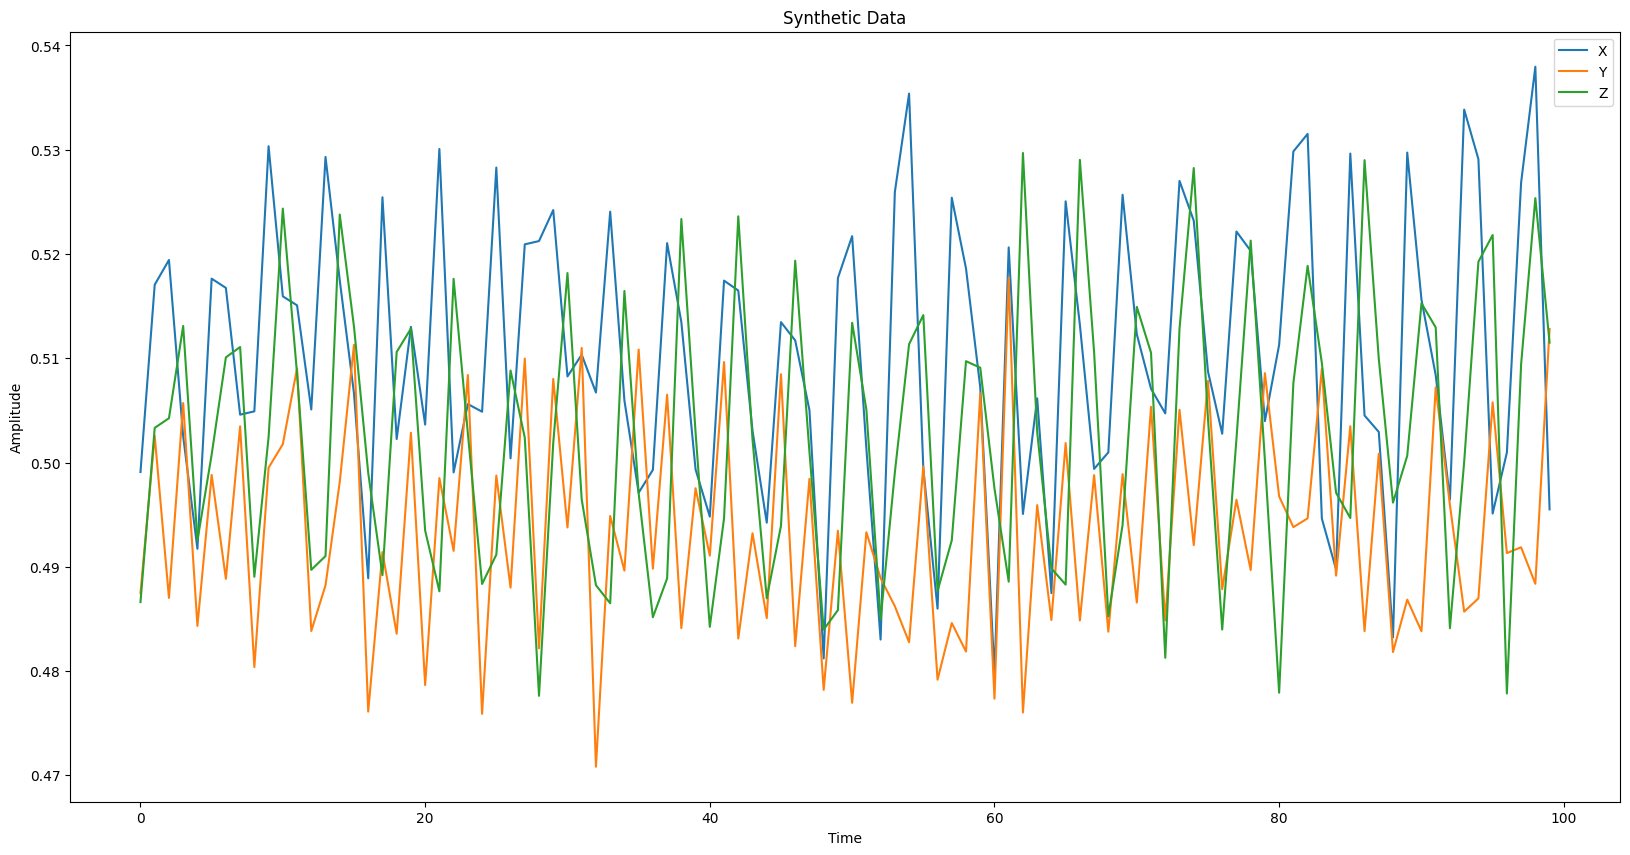

In [66]:
#plot synthetic data
plt.figure(figsize=(20,10))
plt.title('Synthetic Data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(concatenated_data['X'][concatenated_data['y'] == 0][0,:,:3])
plt.legend(['X','Y','Z'])

In [60]:
concatenated_data['X'].shape

(400, 100, 6)

In [ ]:
## Inception Time Implementation
import torch
from torch import nn
import torch.nn.functional as F


class Conv1dSamePadding(nn.Conv1d):
    """Represents the "Same" padding functionality from Tensorflow.
    See: https://github.com/pytorch/pytorch/issues/3867
    Note that the padding argument in the initializer doesn't do anything now
    """
    def forward(self, input):
        return conv1d_same_padding(input, self.weight, self.bias, self.stride,
                                   self.dilation, self.groups)


def conv1d_same_padding(input, weight, bias, stride, dilation, groups):
    # stride and dilation are expected to be tuples.
    kernel, dilation, stride = weight.size(2), dilation[0], stride[0]
    l_out = l_in = input.size(2)
    padding = (((l_out - 1) * stride) - l_in + (dilation * (kernel - 1)) + 1)
    if padding % 2 != 0:
        input = F.pad(input, [0, 1])

    return F.conv1d(input=input, weight=weight, bias=bias, stride=stride,
                    padding=padding // 2,
                    dilation=dilation, groups=groups)


class ConvBlock(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, kernel_size: int,
                 stride: int) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            Conv1dSamePadding(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              stride=stride),
            nn.BatchNorm1d(num_features=out_channels),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore

        return self.layers(x)
    
from typing import cast, Union, List


class InceptionModel(nn.Module):
    """A PyTorch implementation of the InceptionTime model.
    From https://arxiv.org/abs/1909.04939
    Attributes
    ----------
    num_blocks:
        The number of inception blocks to use. One inception block consists
        of 3 convolutional layers, (optionally) a bottleneck and (optionally) a residual
        connector
    in_channels:
        The number of input channels (i.e. input.shape[-1])
    out_channels:
        The number of "hidden channels" to use. Can be a list (for each block) or an
        int, in which case the same value will be applied to each block
    bottleneck_channels:
        The number of channels to use for the bottleneck. Can be list or int. If 0, no
        bottleneck is applied
    kernel_sizes:
        The size of the kernels to use for each inception block. Within each block, each
        of the 3 convolutional layers will have kernel size
        `[kernel_size // (2 ** i) for i in range(3)]`
    num_pred_classes:
        The number of output classes
    """

    def __init__(self, num_blocks: int, in_channels: int, out_channels: Union[List[int], int],
                 bottleneck_channels: Union[List[int], int], kernel_sizes: Union[List[int], int],
                 use_residuals: Union[List[bool], bool, str] = 'default',
                 num_pred_classes: int = 1
                 ) -> None:
        super().__init__()

        # for easier saving and loading
        self.input_args = {
            'num_blocks': num_blocks,
            'in_channels': in_channels,
            'out_channels': out_channels,
            'bottleneck_channels': bottleneck_channels,
            'kernel_sizes': kernel_sizes,
            'use_residuals': use_residuals,
            'num_pred_classes': num_pred_classes
        }

        channels = [in_channels] + cast(List[int], self._expand_to_blocks(out_channels,
                                                                          num_blocks))
        bottleneck_channels = cast(List[int], self._expand_to_blocks(bottleneck_channels,
                                                                     num_blocks))
        kernel_sizes = cast(List[int], self._expand_to_blocks(kernel_sizes, num_blocks))
        if use_residuals == 'default':
            use_residuals = [True if i % 3 == 2 else False for i in range(num_blocks)]
        use_residuals = cast(List[bool], self._expand_to_blocks(
            cast(Union[bool, List[bool]], use_residuals), num_blocks)
        )

        self.blocks = nn.Sequential(*[
            InceptionBlock(in_channels=channels[i], out_channels=channels[i + 1],
                           residual=use_residuals[i], bottleneck_channels=bottleneck_channels[i],
                           kernel_size=kernel_sizes[i]) for i in range(num_blocks)
        ])

        # a global average pooling (i.e. mean of the time dimension) is why
        # in_features=channels[-1]
        self.linear = nn.Linear(in_features=channels[-1], out_features=num_pred_classes)

    @staticmethod
    def _expand_to_blocks(value: Union[int, bool, List[int], List[bool]],
                          num_blocks: int) -> Union[List[int], List[bool]]:
        if isinstance(value, list):
            assert len(value) == num_blocks, \
                f'Length of inputs lists must be the same as num blocks, ' \
                f'expected length {num_blocks}, got {len(value)}'
        else:
            value = [value] * num_blocks
        return value

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        x = self.blocks(x).mean(dim=-1)  # the mean is the global average pooling
        return self.linear(x)


class InceptionBlock(nn.Module):
    """An inception block consists of an (optional) bottleneck, followed
    by 3 conv1d layers. Optionally residual
    """

    def __init__(self, in_channels: int, out_channels: int,
                 residual: bool, stride: int = 1, bottleneck_channels: int = 32,
                 kernel_size: int = 41) -> None:
        assert kernel_size > 3, "Kernel size must be strictly greater than 3"
        super().__init__()

        self.use_bottleneck = bottleneck_channels > 0
        if self.use_bottleneck:
            self.bottleneck = Conv1dSamePadding(in_channels, bottleneck_channels,
                                                kernel_size=1, bias=False)
        kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]
        start_channels = bottleneck_channels if self.use_bottleneck else in_channels
        channels = [start_channels] + [out_channels] * 3
        self.conv_layers = nn.Sequential(*[
            Conv1dSamePadding(in_channels=channels[i], out_channels=channels[i + 1],
                              kernel_size=kernel_size_s[i], stride=stride, bias=False)
            for i in range(len(kernel_size_s))
        ])

        self.batchnorm = nn.BatchNorm1d(num_features=channels[-1])
        self.relu = nn.ReLU()

        self.use_residual = residual
        if residual:
            self.residual = nn.Sequential(*[
                Conv1dSamePadding(in_channels=in_channels, out_channels=out_channels,
                                  kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels),
                nn.ReLU()
            ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        org_x = x
        if self.use_bottleneck:
            x = self.bottleneck(x)
        x = self.conv_layers(x)

        if self.use_residual:
            x = x + self.residual(org_x)
        return 